# Make plots of picks from ELEP

In [ ]:
# pip install --upgrade scipy


Note: you may need to restart the kernel to use updated packages.


In [39]:
import os
import sys
import pandas as pd
# from obspy import UTCDateTime,Stream
# from obspy.clients.fdsn import Client
# from pnwstore.mseed import WaveformClient
# from obspy.geodetics import locations2degrees, degrees2kilometers
# import matplotlib.pyplot as plt
# import numpy as np
# from mpl_toolkits.basemap import Basemap
# from tqdm import tqdm
import datetime
from datetime import timezone
import time

notebook_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_dir, '../utils/'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from plot_utils import *

In [49]:
# Make a directory for this plot
os.makedirs('/wd1/hbito_data/data/datasets_all_regions/fig3', exist_ok=True)

In [48]:
help(os.makedirs)

Help on function makedirs in module os:

makedirs(name, mode=511, exist_ok=False)
    makedirs(name [, mode=0o777][, exist_ok=False])
    
    Super-mkdir; create a leaf directory and all intermediate ones.  Works like
    mkdir, except that any intermediate path segment (not just the rightmost)
    will be created if it does not exist. If the target directory already
    exists, raise an OSError if exist_ok is False. Otherwise no exception is
    raised.  This is recursive.



In [7]:
# Define clients
client_iris = Client("IRIS")
client_pnw = WaveformClient()
client_ncedc = Client('NCEDC')

In [8]:
_df = pd.read_csv('/wd1/hbito_data/data/datasets_all_regions/origin_2010_2015_reloc_cog_morton_ver3.csv')
_df['datetime'] = _df.apply(lambda a: datetime.fromtimestamp(a['time'], tz=timezone.utc), axis=1)
_df


,Unnamed: 0,lat,lon,depth,time,orid,nass,p_picks,s_picks,rms,nsphz,gap,algorithm,id_Morton,dist,dt,NonDimDist,datetime
0,0,47.22533,-122.16895,56.111,1.262305e+09,0,7,2,5,1.081,5.0,235.831208,genie,0,0.753784,4.933721e+07,411143.414481,2010-01-01 00:15:17.262282+00:00
1,1,48.19518,-121.77276,3.820,1.262305e+09,1,55,25,30,0.985,30.0,201.698107,genie,0,1.333054,4.933712e+07,411142.646872,2010-01-01 00:16:49.375360+00:00
2,2,47.86208,-122.09903,17.799,1.262330e+09,2,28,10,18,0.784,18.0,181.023074,genie,0,0.957326,4.931184e+07,410932.027590,2010-01-01 07:18:03.689209+00:00
3,3,47.96435,-122.91906,21.286,1.262336e+09,3,20,10,10,0.465,10.0,150.528010,genie,0,0.684951,4.930621e+07,410885.088574,2010-01-01 08:51:56.371091+00:00
4,4,45.87262,-122.19180,9.822,1.262362e+09,4,39,20,19,0.657,19.0,237.324295,genie,0,1.627692,4.927976e+07,410664.693011,2010-01-01 16:12:43.838660+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63882,63882,40.59439,-124.42438,19.741,1.435097e+09,63882,23,9,14,1.015,14.0,73.959960,genie,4408,0.112501,7.919735e+03,65.997794,2015-06-23 22:11:15.735288+00:00
63883,63883,40.54636,-127.10076,26.165,1.435100e+09,63883,12,1,11,0.744,11.0,223.080984,genie,4408,2.139193,9.995899e+03,83.299204,2015-06-23 22:45:51.899203+00:00
63884,63884,49.74167,-124.58578,5.274,1.435101e+09,63884,13,7,6,0.894,6.0,197.904075,genie,4408,9.188393,1.107364e+04,92.281049,2015-06-23 23:03:49.638010+00:00
63885,63885,40.64363,-125.36531,1.891,1.435101e+09,63885,8,3,5,0.982,5.0,145.748415,genie,4408,0.824720,1.158579e+04,96.548245,2015-06-23 23:12:21.788775+00:00


## Load catalogs from Morton (2023) and ANSS

In [9]:
# Read Morton's catalog
events_morton = pd.read_csv('../data/ds01.csv')
# Convert the TSTRING to datetime
events_morton['datetime'] = pd.to_datetime(events_morton['TSTRING'], format='%Y%m%d%H%M%S', utc=True)
# Get the events in the Morton catalog 
# t1 = pd.Timestamp('2011-1-1 00:00:00.000000+0000', tz='UTC')
# t2 = pd.Timestamp('2015-12-31 23:59:59.999999+0000', tz='UTC')

# events_morton= events_morton.loc[(events_morton['datetime'] > t1) & (events_morton['datetime'] < t2) ]

events_morton.head()

,CI YEAR,TSTRING,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,LAT,LON,...,dist to nearest stn,tt RMS,ERH,ERZ,STRIKE,DIP,RAKE,PLATE DESIGNATION,TEMPLATE EVENT?,datetime
0,1.0,2.011073e+13,2011.0,7.0,26.0,1.0,2.0,7.37,47.3217,-123.2708,...,27.4,0.19,0.8,1.2,NaN,NaN,NaN,Interface,Catalog,2011-07-26 01:02:07+00:00
1,1.0,2.011073e+13,2011.0,7.0,26.0,1.0,2.0,7.72,44.2888,-124.3340,...,163.8,0.06,13.1,3.2,NaN,NaN,NaN,Upper Plate,NaN,2011-07-26 01:02:07+00:00
2,1.0,2.011073e+13,2011.0,7.0,26.0,1.0,2.0,8.56,44.3017,-124.3180,...,131.1,0.50,35.4,22.2,NaN,NaN,NaN,Upper Plate,NaN,2011-07-26 01:02:08+00:00
3,1.0,2.011073e+13,2011.0,7.0,26.0,7.0,31.0,2.17,48.2635,-124.9298,...,44.4,0.77,3.5,6.4,NaN,NaN,NaN,Upper Plate,NaN,2011-07-26 07:31:02+00:00
4,1.0,2.011073e+13,2011.0,7.0,26.0,9.0,50.0,27.63,48.3032,-124.9157,...,46.1,0.94,4.0,6.9,NaN,NaN,NaN,Upper Plate,T,2011-07-26 09:50:27+00:00


In [10]:
events_anss = pd.read_csv('/wd1/hbito_data/data/datasets_anss/anss_2010-15.csv')
events_anss['datetime'] = pd.to_datetime(events_anss['time'], format='%Y-%m-%dT%H:%M:%S.%fZ', utc=True)
# events_anss= events_anss.loc[(events_anss['datetime'] > t1) & (events_anss['datetime'] < t2) ]
events_anss

,Unnamed: 0,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,datetime
0,0,2010-01-01T00:16:49.190Z,48.203167,-121.676833,2.948,2.20,md,16.0,79.0,0.167900,...,"8 km SW of Darrington, Washington",earthquake,1.004,12.60,0.070,9.0,reviewed,uw,uw,2010-01-01 00:16:49.190000+00:00
1,1,2010-01-01T01:09:53.550Z,38.755167,-122.717167,1.604,0.20,md,9.0,67.0,0.015320,...,"7 km S of Cobb, California",earthquake,0.500,1.19,0.175,4.0,reviewed,nc,nc,2010-01-01 01:09:53.550000+00:00
2,2,2010-01-01T01:28:40.410Z,38.824167,-122.814667,1.479,0.29,md,15.0,90.0,0.003604,...,"7 km W of Cobb, California",earthquake,0.250,0.33,0.273,4.0,reviewed,nc,nc,2010-01-01 01:28:40.410000+00:00
3,3,2010-01-01T01:28:44.590Z,38.825500,-122.815333,1.859,0.65,md,7.0,106.0,0.004505,...,"8 km W of Cobb, California",earthquake,1.220,1.78,NaN,1.0,reviewed,nc,nc,2010-01-01 01:28:44.590000+00:00
4,4,2010-01-01T01:45:21.220Z,38.813332,-122.785500,0.739,0.97,md,15.0,56.0,0.009009,...,"5 km W of Cobb, California",earthquake,0.200,0.49,0.120,16.0,automatic,nc,nc,2010-01-01 01:45:21.220000+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151785,151785,2015-12-31T22:15:46.650Z,38.837502,-122.825333,1.450,0.18,md,6.0,180.0,0.008108,...,"9 km W of Cobb, California",earthquake,0.660,1.08,0.110,2.0,automatic,nc,nc,2015-12-31 22:15:46.650000+00:00
151786,151786,2015-12-31T22:18:13.120Z,41.856400,-119.599200,8.700,1.40,ml,6.0,210.1,0.175000,...,"45 km E of Fort Bidwell, California",earthquake,NaN,3.40,0.210,3.0,reviewed,nn,nn,2015-12-31 22:18:13.120000+00:00
151787,151787,2015-12-31T23:19:21.650Z,38.823334,-122.765663,1.680,0.54,md,7.0,99.0,0.008108,...,"3 km W of Cobb, California",earthquake,0.500,1.54,0.030,2.0,automatic,nc,nc,2015-12-31 23:19:21.650000+00:00
151788,151788,2015-12-31T23:22:20.730Z,38.841000,-122.878166,1.730,0.77,md,8.0,95.0,0.007207,...,"12 km ENE of Cloverdale, California",earthquake,0.580,1.02,0.180,3.0,automatic,nc,nc,2015-12-31 23:22:20.730000+00:00


## (a)

In [11]:
# Good association: Offshore WA
event_a = _df.loc[(_df['lat']>=46.97)&(_df['lat']<=46.99)&(_df['lon']<=-124.74)&(_df['lon']>=-124.76)]
event_a

,Unnamed: 0,lat,lon,depth,time,orid,nass,p_picks,s_picks,rms,nsphz,gap,algorithm,id_Morton,dist,dt,NonDimDist,datetime
52800,52800,46.97998,-124.75515,15.409,1.413533e+09,52800,81,38,43,0.96,43.0,83.470991,genie,2513,6.569731,9487.333491,79.061549,2014-10-17 07:58:38.666509+00:00


In [12]:

# Localize (not convert) the naive timestamp to UTC
time_center = pd.to_datetime(event_a['datetime'].values[0]).tz_localize('UTC')
time_window = pd.to_timedelta(120, unit='s')

# Apply mask to timezone-aware datetimes
mask = (events_morton['datetime'] >= time_center - time_window) & \
       (events_morton['datetime'] <= time_center + time_window)

events_morton.loc[mask]


,CI YEAR,TSTRING,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,LAT,LON,...,dist to nearest stn,tt RMS,ERH,ERZ,STRIKE,DIP,RAKE,PLATE DESIGNATION,TEMPLATE EVENT?,datetime


In [13]:

# Localize (not convert) the naive timestamp to UTC
time_center = pd.to_datetime(event_a['datetime'].values[0]).tz_localize('UTC')
time_window = pd.to_timedelta(120, unit='s')

# Apply mask to timezone-aware datetimes
mask = (events_anss['datetime'] >= time_center - time_window) & \
       (events_anss['datetime'] <= time_center + time_window)

events_anss.loc[mask]

,Unnamed: 0,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,datetime
119619,119619,2014-10-17T07:58:38.470Z,46.965167,-124.867833,39.643,1.59,md,18.0,244.0,0.7488,...,"54 km W of Oyehut, Washington",earthquake,2.02,0.96,0.107,5.0,reviewed,uw,uw,2014-10-17 07:58:38.470000+00:00


## (b)

In [14]:
# Good association: Offshore OR
event_b = _df.loc[(_df['lat']>=44.37)&(_df['lat']<=44.39)&(_df['lon']<=-124.45)&(_df['lon']>=-124.47)].iloc[2]
event_b

Unnamed: 0                               20052
lat                                   44.38373
lon                                 -124.46256
depth                                   10.063
time                         1332235717.680858
orid                                     20052
nass                                        80
p_picks                                     43
s_picks                                     37
rms                                      1.206
nsphz                                     37.0
gap                                  70.022537
algorithm                                genie
id_Morton                                  194
dist                                  0.048454
dt                                    0.680858
NonDimDist                            0.005996
datetime      2012-03-20 09:28:37.680858+00:00
Name: 20052, dtype: object

In [15]:
event_b['datetime']

Timestamp('2012-03-20 09:28:37.680858+0000', tz='UTC')

In [16]:

# Localize (not convert) the naive timestamp to UTC
time_center = pd.to_datetime(event_b['datetime'])
time_window = pd.to_timedelta(120, unit='s')

# Apply mask to timezone-aware datetimes
mask = (events_morton['datetime'] >= time_center - time_window) & \
       (events_morton['datetime'] <= time_center + time_window)

events_morton.loc[mask]

,CI YEAR,TSTRING,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,LAT,LON,...,dist to nearest stn,tt RMS,ERH,ERZ,STRIKE,DIP,RAKE,PLATE DESIGNATION,TEMPLATE EVENT?,datetime
194,1.0,2.012032e+13,2012.0,3.0,20.0,9.0,28.0,37.0,44.3517,-124.4117,...,21.5,0.42,0.9,2.0,NaN,NaN,NaN,Interface,T,2012-03-20 09:28:37+00:00


In [17]:

# Localize (not convert) the naive timestamp to UTC
time_center = pd.to_datetime(event_b['datetime'])
time_window = pd.to_timedelta(120, unit='s')

# Apply mask to timezone-aware datetimes
mask = (events_anss['datetime'] >= time_center - time_window) & \
       (events_anss['datetime'] <= time_center + time_window)

events_anss.loc[mask]

,Unnamed: 0,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,datetime
52043,52043,2012-03-20T09:28:37.350Z,44.383333,-124.456333,32.93,3.7,ml,16.0,228.0,0.3795,...,"29 km WNW of Yachats, Oregon",earthquake,0.81,1.07,0.18,82.0,reviewed,uw,uw,2012-03-20 09:28:37.350000+00:00


## (c)

In [18]:
# Good association: Northern California
event_c = _df.loc[(_df['lat']>=40.84)&(_df['lat']<=40.86)&(_df['lon']<=-123.36)&(_df['lon']>=-123.38)]
event_c

,Unnamed: 0,lat,lon,depth,time,orid,nass,p_picks,s_picks,rms,nsphz,gap,algorithm,id_Morton,dist,dt,NonDimDist,datetime
55331,55331,40.85222,-123.3666,26.107,1.418415e+09,55331,22,10,12,1.586,12.0,102.274632,genie,2924,0.047893,1.349966,0.011412,2014-12-12 20:16:44.349966+00:00


In [19]:

# Localize (not convert) the naive timestamp to UTC
time_center = pd.to_datetime(event_c['datetime'].values[0]).tz_localize('UTC')
time_window = pd.to_timedelta(120, unit='s')

# Apply mask to timezone-aware datetimes
mask = (events_morton['datetime'] >= time_center - time_window) & \
       (events_morton['datetime'] <= time_center + time_window)

events_morton.loc[mask]

,CI YEAR,TSTRING,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,LAT,LON,...,dist to nearest stn,tt RMS,ERH,ERZ,STRIKE,DIP,RAKE,PLATE DESIGNATION,TEMPLATE EVENT?,datetime
2924,4.0,2.014121e+13,2014.0,12.0,12.0,20.0,16.0,43.27,40.888,-123.3245,...,26.8,0.1,0.6,1.4,164.24,63.48,26.76,Interface,NaN,2014-12-12 20:16:43+00:00


In [20]:

# Localize (not convert) the naive timestamp to UTC
time_center = pd.to_datetime(event_c['datetime'].values[0]).tz_localize('UTC')
time_window = pd.to_timedelta(120, unit='s')

# Apply mask to timezone-aware datetimes
mask = (events_anss['datetime'] >= time_center - time_window) & \
       (events_anss['datetime'] <= time_center + time_window)

events_anss.loc[mask]

,Unnamed: 0,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,datetime


## (d)

In [21]:
# Bad association:Northern California
event_d = _df.loc[(_df['lat']>=40.52)&(_df['lat']<=40.54)&(_df['lon']<=-124.73)&(_df['lon']>=-124.75)].iloc[3]
event_d

Unnamed: 0                                 535
lat                                   40.53275
lon                                 -124.73816
depth                                   11.093
time                         1263264837.458611
orid                                       535
nass                                         8
p_picks                                      3
s_picks                                      5
rms                                        0.2
nsphz                                      5.0
gap                                 258.774701
algorithm                                genie
id_Morton                                    1
dist                                   3.76787
dt                             48377289.541389
NonDimDist                       403144.079512
datetime      2010-01-12 02:53:57.458611+00:00
Name: 535, dtype: object

In [22]:
event_d['datetime']

Timestamp('2010-01-12 02:53:57.458611+0000', tz='UTC')

In [23]:

# Localize (not convert) the naive timestamp to UTC
time_center = pd.to_datetime(event_d['datetime'])
time_window = pd.to_timedelta(120, unit='s')

# Apply mask to timezone-aware datetimes
mask = (events_morton['datetime'] >= time_center - time_window) & \
       (events_morton['datetime'] <= time_center + time_window)

events_morton.loc[mask]

,CI YEAR,TSTRING,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,LAT,LON,...,dist to nearest stn,tt RMS,ERH,ERZ,STRIKE,DIP,RAKE,PLATE DESIGNATION,TEMPLATE EVENT?,datetime


In [24]:

# Localize (not convert) the naive timestamp to UTC
time_center = pd.to_datetime(event_d['datetime'])
time_window = pd.to_timedelta(120, unit='s')

# Apply mask to timezone-aware datetimes
mask = (events_anss['datetime'] >= time_center - time_window) & \
       (events_anss['datetime'] <= time_center + time_window)

events_anss.loc[mask]

,Unnamed: 0,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,datetime
640,640,2010-01-12T02:53:36.370Z,40.5075,-124.882,14.078,3.18,ml,37.0,243.0,0.4162,...,"52 km W of Ferndale, California",earthquake,1.39,0.69,0.165,17.0,reviewed,nc,nc,2010-01-12 02:53:36.370000+00:00


## (e)

In [25]:
# Bad association: Columbia River
event_e = _df.loc[(_df['lat']>=46.24)&(_df['lat']<=46.26)&(_df['lon']<=-122.69)&(_df['lon']>=-122.71)]
event_e

,Unnamed: 0,lat,lon,depth,time,orid,nass,p_picks,s_picks,rms,nsphz,gap,algorithm,id_Morton,dist,dt,NonDimDist,datetime
29,29,46.24845,-122.70049,47.728,1.262489e+09,29,8,6,2,0.443,2.0,252.366215,genie,0,1.142079,4.915355e+07,409612.903718,2010-01-03 03:16:18.553785+00:00


In [26]:

# Localize (not convert) the naive timestamp to UTC
time_center = pd.to_datetime(event_e['datetime'].values[0]).tz_localize('UTC')
time_window = pd.to_timedelta(120, unit='s')

# Apply mask to timezone-aware datetimes
mask = (events_morton['datetime'] >= time_center - time_window) & \
       (events_morton['datetime'] <= time_center + time_window)

events_morton.loc[mask]

,CI YEAR,TSTRING,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,LAT,LON,...,dist to nearest stn,tt RMS,ERH,ERZ,STRIKE,DIP,RAKE,PLATE DESIGNATION,TEMPLATE EVENT?,datetime


In [27]:

# Localize (not convert) the naive timestamp to UTC
time_center = pd.to_datetime(event_e['datetime'].values[0]).tz_localize('UTC')
time_window = pd.to_timedelta(120, unit='s')

# Apply mask to timezone-aware datetimes
mask = (events_anss['datetime'] >= time_center - time_window) & \
       (events_anss['datetime'] <= time_center + time_window)

events_anss.loc[mask]

,Unnamed: 0,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,datetime


## (f)

In [28]:
# Bad association: Offshore OR
event_f = _df.loc[(_df['lat']>=41.83)&(_df['lat']<=41.85)&(_df['lon']<=-124.94)&(_df['lon']>=-124.96)]
event_f

,Unnamed: 0,lat,lon,depth,time,orid,nass,p_picks,s_picks,rms,nsphz,gap,algorithm,id_Morton,dist,dt,NonDimDist,datetime
54736,54736,41.83504,-124.9547,57.795,1.417095e+09,54736,11,5,6,1.51,6.0,167.808554,genie,2838,1.430578,6845.349945,57.044612,2014-11-27 13:28:35.349945+00:00


In [29]:

# Localize (not convert) the naive timestamp to UTC
time_center = pd.to_datetime(event_f['datetime'].values[0]).tz_localize('UTC')
time_window = pd.to_timedelta(120, unit='s')

# Apply mask to timezone-aware datetimes
mask = (events_morton['datetime'] >= time_center - time_window) & \
       (events_morton['datetime'] <= time_center + time_window)

events_morton.loc[mask]

,CI YEAR,TSTRING,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,LAT,LON,...,dist to nearest stn,tt RMS,ERH,ERZ,STRIKE,DIP,RAKE,PLATE DESIGNATION,TEMPLATE EVENT?,datetime


In [30]:

# Localize (not convert) the naive timestamp to UTC
time_center = pd.to_datetime(event_f['datetime'].values[0]).tz_localize('UTC')
time_window = pd.to_timedelta(120, unit='s')

# Apply mask to timezone-aware datetimes
mask = (events_anss['datetime'] >= time_center - time_window) & \
       (events_anss['datetime'] <= time_center + time_window)

events_anss.loc[mask]

,Unnamed: 0,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,datetime
123671,123671,2014-11-27T13:27:41.810Z,38.807835,-122.793503,0.45,0.52,md,9.0,116.0,0.001802,...,"6 km WSW of Cobb, California",earthquake,0.6,0.82,0.02,2.0,automatic,nc,nc,2014-11-27 13:27:41.810000+00:00


### Plot the figure

In [31]:
_df = pd.read_csv('/wd1/hbito_data/data/datasets_all_regions/origin_2010_2015_reloc_cog_morton_ver3.csv',index_col=0)
_df["time"] = _df["time"].apply(datetime.fromtimestamp, tz=timezone.utc)

df_arrival = pd.read_csv('/wd1/hbito_data/data/datasets_all_regions/arrival_2010_2015_reloc_cog_ver3.csv',index_col=0)

df_assoc = pd.read_csv('/wd1/hbito_data/data/datasets_all_regions/assoc_2010_2015_reloc_cog_ver3.csv',index_col=0)[['orid','arid']]

df_picks = df_assoc.merge(df_arrival, on='arid', how='inner')[['orid','arid','sta','iphase','time']]
df_picks = df_picks.rename(columns={'time':'time_pick'})
df_pick_assignments = _df.merge(df_picks, on='orid', how='inner')

df_pick_assignments = df_pick_assignments.rename(columns={'orid':'idx','sta':'station','iphase':'phase','datetime':'time','arid':'pick_idx','lat':'latitude','lon':'longitude'})


picks = df_pick_assignments



pick_idx = picks.idx.unique()[:]
picks_selected = picks[picks.idx.isin(pick_idx)]
picks_selected.loc[:, 'phase'] = picks_selected['phase'].str.replace(' ', '')
picks_selected.loc[:, 'station'] = picks_selected['station'].str.replace(' ', '')
picks_selected.loc[:, 'station'] = picks_selected['station'].apply(lambda x: x + '.')

In [32]:
picks

,latitude,longitude,depth,time,idx,nass,p_picks,s_picks,rms,nsphz,gap,algorithm,id_Morton,dist,dt,NonDimDist,pick_idx,station,phase,time_pick
0,47.22533,-122.16895,56.111,2010-01-01 00:15:17.262282+00:00,0,7,2,5,1.081,5.0,235.831208,genie,0,0.753784,4.933721e+07,411143.414481,0,UW.PCMD,P,1.262305e+09
1,47.22533,-122.16895,56.111,2010-01-01 00:15:17.262282+00:00,0,7,2,5,1.081,5.0,235.831208,genie,0,0.753784,4.933721e+07,411143.414481,1,UW.RVW,P,1.262305e+09
2,47.22533,-122.16895,56.111,2010-01-01 00:15:17.262282+00:00,0,7,2,5,1.081,5.0,235.831208,genie,0,0.753784,4.933721e+07,411143.414481,2,UW.PCMD,S,1.262305e+09
3,47.22533,-122.16895,56.111,2010-01-01 00:15:17.262282+00:00,0,7,2,5,1.081,5.0,235.831208,genie,0,0.753784,4.933721e+07,411143.414481,3,UW.GNW,S,1.262305e+09
4,47.22533,-122.16895,56.111,2010-01-01 00:15:17.262282+00:00,0,7,2,5,1.081,5.0,235.831208,genie,0,0.753784,4.933721e+07,411143.414481,4,PB.B013,S,1.262305e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004330,43.37085,-127.35251,5.915,2015-06-23 23:18:18.841147+00:00,63886,9,4,5,0.447,5.0,247.683119,genie,4408,3.622500,1.194284e+04,99.523782,1004330,7D.J11D,S,1.435102e+09
1004331,43.37085,-127.35251,5.915,2015-06-23 23:18:18.841147+00:00,63886,9,4,5,0.447,5.0,247.683119,genie,4408,3.622500,1.194284e+04,99.523782,1004331,7D.G35D,S,1.435102e+09
1004332,43.37085,-127.35251,5.915,2015-06-23 23:18:18.841147+00:00,63886,9,4,5,0.447,5.0,247.683119,genie,4408,3.622500,1.194284e+04,99.523782,1004332,7D.J19D,S,1.435102e+09
1004333,43.37085,-127.35251,5.915,2015-06-23 23:18:18.841147+00:00,63886,9,4,5,0.447,5.0,247.683119,genie,4408,3.622500,1.194284e+04,99.523782,1004333,7D.J10D,S,1.435102e+09


In [28]:

picks.loc[picks['idx']==29]

,latitude,longitude,depth,time,idx,nass,p_picks,s_picks,rms,nsphz,gap,algorithm,id_Morton,dist,dt,NonDimDist,pick_idx,station,phase,time_pick
576,46.24845,-122.70049,47.728,2010-01-03 03:16:18.553785+00:00,29,8,6,2,0.443,2.0,252.366215,genie,0,1.142079,4.915355e+07,409612.903718,576,UW.LCW,P,1.262489e+09
577,46.24845,-122.70049,47.728,2010-01-03 03:16:18.553785+00:00,29,8,6,2,0.443,2.0,252.366215,genie,0,1.142079,4.915355e+07,409612.903718,577,UW.STD,P,1.262489e+09
578,46.24845,-122.70049,47.728,2010-01-03 03:16:18.553785+00:00,29,8,6,2,0.443,2.0,252.366215,genie,0,1.142079,4.915355e+07,409612.903718,578,UW.HSR,P,1.262489e+09
579,46.24845,-122.70049,47.728,2010-01-03 03:16:18.553785+00:00,29,8,6,2,0.443,2.0,252.366215,genie,0,1.142079,4.915355e+07,409612.903718,579,UW.SOS,P,1.262489e+09
580,46.24845,-122.70049,47.728,2010-01-03 03:16:18.553785+00:00,29,8,6,2,0.443,2.0,252.366215,genie,0,1.142079,4.915355e+07,409612.903718,580,UW.FL2,P,1.262489e+09
581,46.24845,-122.70049,47.728,2010-01-03 03:16:18.553785+00:00,29,8,6,2,0.443,2.0,252.366215,genie,0,1.142079,4.915355e+07,409612.903718,581,UW.TDL,P,1.262489e+09
582,46.24845,-122.70049,47.728,2010-01-03 03:16:18.553785+00:00,29,8,6,2,0.443,2.0,252.366215,genie,0,1.142079,4.915355e+07,409612.903718,582,PB.B013,S,1.262489e+09
583,46.24845,-122.70049,47.728,2010-01-03 03:16:18.553785+00:00,29,8,6,2,0.443,2.0,252.366215,genie,0,1.142079,4.915355e+07,409612.903718,583,PB.B943,S,1.262489e+09


In [33]:
# p_pick = event_picks.loc[(event_picks.station==station)]


In [34]:
# p_pick

In [35]:
# station

In [41]:
import scipy.signal as signal
from scipy.signal import windows

if not hasattr(signal, 'hann'):
    signal.hann = windows.hann

/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/jupyter_share/miniconda3/envs/

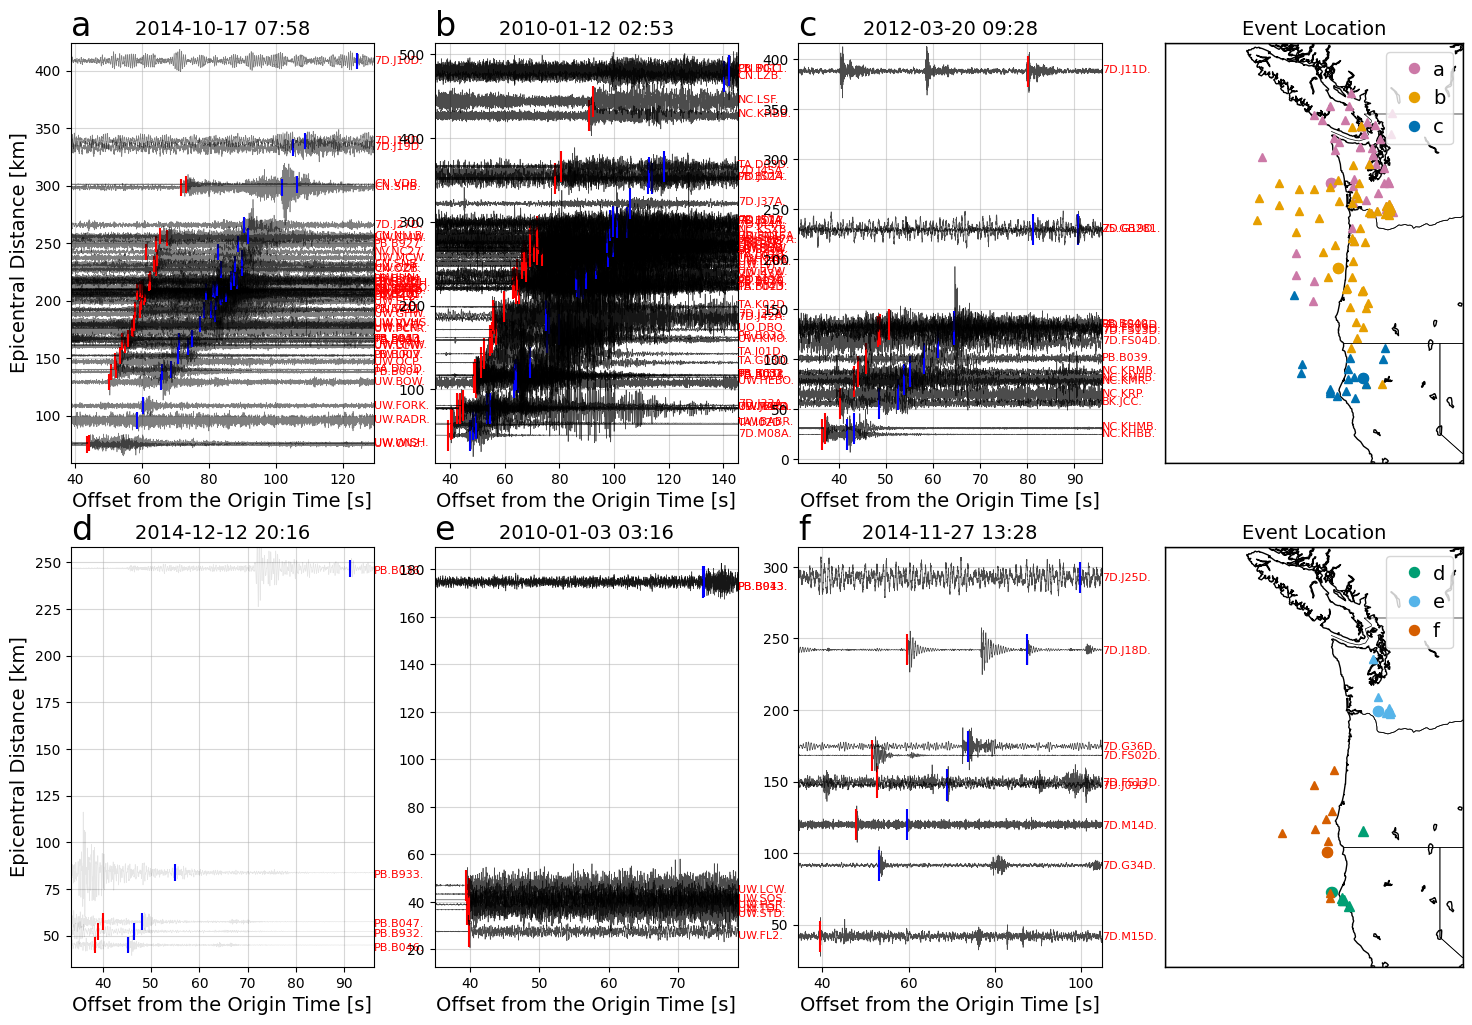

In [66]:
fig, axs = plt.subplots(2, 4, figsize=(18, 12))
###################################################
event_idx = 52800
event_picks = picks[picks.idx==event_idx]
event_stations = event_picks.station.unique()
# print(event_picks)

otime = UTCDateTime(pd.to_datetime(event_picks.iloc[0].time))
olat = event_picks.iloc[0].latitude
olon = event_picks.iloc[0].longitude
odepth = event_picks.iloc[0].depth

tstring = otime.strftime('%Y%m%dT%H%M%SZ')
# path = dir + f"{tstring}.png"
# if os.path.exists(path):
#     print(f"File {path} already exists. Skipping.")
#     continue

bulk_sta = []
for sta in event_stations:
    network = sta.split('.')[0]
    station = sta.split('.')[1]
    loc = '*'
    ch = '?H?' 
    t1 = otime- pd.Timedelta(1,'days')
    t2 = otime + pd.Timedelta(1,'days')

    bulk_sta.append([network,station,loc,ch,t1,t2])
    
inv = client_iris.get_stations_bulk(bulk_sta)

time.sleep(0.1)


distances = []
for network in inv:
    network_code = network.code
    for sta in network:
        station_code = sta.code
        slat = sta.latitude
        slon = sta.longitude
        selev = sta.elevation
        
        dis1 = locations2degrees(olat, olon, slat, slon)
        dist = degrees2kilometers(dis1)

        distances.append([network_code,station_code,olat,olon,odepth,slat,slon,selev,dist])
        
# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
st = Stream()

starttime = otime - 30
endtime = otime + 200
ch = '?H?'
loc = '*'

# Set up to define the xlim and ylim
max_y = 0
min_y = 0
min_y_count = 0 

max_x = 0
min_x = 0
min_x_count= 0

bulk_ncedc = []
bulk_pnw = []

for item in distances:
    network_code, station_code, olat, olon, odepth, slat, slon, selev, dist = item

    # Make a bulk request for the waveforms
    if network_code in ['NC','BK']:
        bulk_ncedc.append([network_code,station_code,loc,ch,starttime,endtime])
    else:
        bulk_pnw.append([network_code,station_code,loc,ch,starttime,endtime])
    

    # Adjust the time window and scaling of the data
    station = network_code+'.'+station_code
    p_pick = event_picks.loc[(event_picks.station==station)&(event_picks.phase=='P')]
    s_pick = event_picks.loc[(event_picks.station==station)&(event_picks.phase=='S')]
    # Append p_pick and s_pick to distances
    item.extend([p_pick,s_pick])
    if len(p_pick)==0 and len(s_pick)==0:
        print('No picks for this station. Skipping.')
        continue

    if len(s_pick) > 0:
        if max_x < UTCDateTime(s_pick.iloc[0]['time_pick']) - starttime:
            max_x = UTCDateTime(s_pick.iloc[0]['time_pick']) + pd.Timedelta(seconds=5) - starttime
    elif len(p_pick) > 0:
        if max_x < UTCDateTime(p_pick.iloc[0]['time_pick']) - starttime: 
            max_x = UTCDateTime(p_pick.iloc[0]['time_pick']) + pd.Timedelta(seconds=5)- starttime
    else:
        print('No picks for this station. Skipping.')
        continue 

    if len(p_pick) > 0:
        if min_x_count == 0:
            if min_x < UTCDateTime(p_pick.iloc[0]['time_pick']) - starttime:
                min_x = UTCDateTime(p_pick.iloc[0]['time_pick']) -pd.Timedelta(seconds=5) - starttime
                min_x_count += 1           
        else:
            if min_x >= UTCDateTime(p_pick.iloc[0]['time_pick']) - starttime:
                min_x = UTCDateTime(p_pick.iloc[0]['time_pick'])-pd.Timedelta(seconds=5) - starttime            
    elif len(s_pick) > 0:
        if min_x_count == 0:
            if min_x < UTCDateTime(s_pick.iloc[0]['time_pick'])- starttime:
                min_x = UTCDateTime(s_pick.iloc[0]['time_pick']) - pd.Timedelta(seconds=5)- starttime
                min_x_count += 1                
        else:
            if min_x >= UTCDateTime(s_pick.iloc[0]['time_pick'])- starttime:
                min_x = UTCDateTime(s_pick.iloc[0]['time_pick']) - pd.Timedelta(seconds=5) - starttime
    else:
        print('No picks for this station. Skipping.')
        continue    

    if min_y_count == 0:
        if min_y < dist:
            min_y = dist - 5
            min_y_count += 1           
    else:
        if min_y >= dist:
            min_y = dist - 5 

    max_y = dist + 5

    distances


alpha_panel_a = 0.5  # Alpha set to 0.5 for this panel 
add_scale_panel_a = 1/2
scaling_factor = (1/2) * (max_y - min_y) * add_scale_panel_a # The last 1/2 added for this panel

    
# Download the waveforms
st_ncedc = Stream()
st_pnw = Stream()
if len(bulk_ncedc) > 0:
    st_ncedc += client_ncedc.get_waveforms_bulk(bulk_ncedc)

time.sleep(0.1) # Pause the execution for 0.1 sec

if len(bulk_pnw) > 0:
    st_pnw += client_pnw.get_waveforms_bulk(bulk_pnw)

time.sleep(0.1) # Pause the execution for 0.1 sec

st = st_ncedc + st_pnw   

st = Stream(filter(lambda st: st.stats.sampling_rate > 10, st))
st.taper(max_percentage=0.05)
st.filter(type='bandpass', freqmin=2, freqmax=25)
st.merge(fill_value='interpolate')

# # Plot the waveforms
# # print('test1',st)
# fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Plot the event and station locations
m1 = Basemap(projection='merc', llcrnrlat=38, urcrnrlat=51, llcrnrlon=-132, urcrnrlon=-119, resolution='i', ax=axs[0,3])
m1.drawcoastlines()
m1.drawcountries()
m1.drawstates()
m1.drawmapboundary()
# m.drawparallels(np.arange(38, 51, 2), labels=[1, 0, 0, 0])
# m.drawmeridians(np.arange(-132, -119, 2), labels=[0, 0, 0, 1],rotation=45)
axs[0,3].set_title('Event Location',fontsize=14)
# # Count the number of stations that have 3 components
# count_1 = 0
# count_2 = 0
# count_3 = 0

for i,item in enumerate(distances):
    network_code, station_code, olat, olon, odepth, slat, slon, selev, dist,p_pick,s_pick = item
    st_sta = st.select(network=network_code,station=station_code)

    # Select only HH or BH channels
    _st = Stream()
    has_HH = bool(st_sta.select(channel="HHZ"))
    has_BH = bool(st_sta.select(channel="BHZ"))
    has_EH = bool(st_sta.select(channel="EHZ"))

    if has_HH:
        # If all HH, BH, EH, and EN channels are present, select only HH
        _st += st_sta.select(channel="HHZ")
    elif has_BH:
        # If BH, EH, and EN channels are present, select only BH
        _st += st_sta.select(channel="BHZ")
    elif has_EH:
        # If only EH and EN channels are present, select only EH
        # NTS: This may result in getting only vertical component data - EH? is used for PNSN analog stations
        # NTS: This may also be tricky for pulling full day-volumes because the sampling rate shifts for
        #      analog stations due to the remote digitization scheme used with analog stations
        _st += st_sta.select(channel="EHZ")
    else:
        continue
    
    # # Define the desired order of channels
    # desired_order = {
    #     'Z': ['HHZ', 'BHZ','EHZ'],
    #     'N': ['HHN', 'HH1', 'BHN', 'BH1', 'EHN', 'EN1'],
    #     'E': ['HHE', 'HH2', 'BHE', 'BH2', 'EHE', 'EN2'],
    # }

    # Function to map channels to their desired order
    # def get_channel_priority(channel):
    #     for priority, (key, values) in enumerate(desired_order.items()):
    #         if channel in values:
    #             return priority
    #     return float('inf')  # Return a high value for channels not in the desired order

    # # Sort the traces in trim_st based on the desired order
    # _st = sorted(_st, key=lambda trace: get_channel_priority(trace.stats.channel))

    _st = Stream(_st)
    # print(_st)
    # for ax in range(len(_st)):
    tr = _st[0]
    sampling_rate = tr.stats.sampling_rate
    channel = tr.stats.channel
    
    tr = tr.normalize()
    
    if len(p_pick) > 0:
        tp = UTCDateTime(p_pick.iloc[0]['time_pick']) - otime + 30
        i1 = int((tp-5) * sampling_rate)
        i2 = int((tp+15) * sampling_rate)
    elif len(s_pick) > 0:
        ts = UTCDateTime(s_pick.iloc[0]['time_pick']) - otime + 30
        i1 = int((ts-10) * sampling_rate)
        i2 = int((ts+10) * sampling_rate)
    else:
        print(f"WARNING: No pick time for {network}.{station}.{channel} on {otime}.")



    offsets1 = dist
    # print(offsets1)
    try: 
        wave = tr.data
        wave = wave / (np.nanmax(wave[i1:i2], axis=-1) * 10)
    except:
        continue 

    # Plot the waveform
    axs[0,0].plot(tr.times(), wave * scaling_factor + offsets1, 
                    color='black', alpha=alpha_panel_a, lw=0.5) 
    if len(p_pick) > 0:
        axs[0,0].vlines(UTCDateTime(p_pick.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/12) * scaling_factor, 
                        offsets1 + (1/12) * scaling_factor, color='r')
    if len(s_pick) > 0:
        axs[0,0].vlines(UTCDateTime(s_pick.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/12) * scaling_factor, 
                        offsets1 + (1/12) * scaling_factor, color='b')
    station = item[0]+'.'+item[1]+'.'
    offsets1 = item[-3]
    axs[0,0].text(max_x, offsets1-4, 
                    station, fontsize=8, color='red', verticalalignment='bottom')
    

    
    axs[0,0].set_ylim([min_y-(1/8) * scaling_factor, max_y+(1/8) * scaling_factor])
    axs[0,0].set_xlim([min_x, max_x])
    axs[0,0].grid(alpha=0.5)
    

    x_sta,y_sta = m1(slon,slat)
    m1.plot(x_sta, y_sta, '^', color='#CC79A7', markersize=6.2)

axs[0,0].set_xlabel('Offset from the Origin Time [s]',fontsize=14)
axs[0,0].set_ylabel('Epicentral Distance [km]',x=0.09,fontsize=14)
axs[0,0].text(min_x, max_y+(1/8) * scaling_factor, 
                'a', fontsize=24, color='black', verticalalignment='bottom')

# Update the title of the subplot with the shortened otime
formatted_otime = otime.strftime('%Y-%m-%d %H:%M')
axs[0,0].set_title(f"{formatted_otime}", fontsize=14)

# # # Plot the event location
x_event,y_event = m1(olon,olat)
m1.plot(x_event, y_event, 'o',color='#CC79A7', markersize=7.2)
m1.plot(x_event+180, y_event+180, 'o',color='#CC79A7', markersize=7.2,label='a')


###################################################
event_idx = 535
event_picks = picks[picks.idx==event_idx]
event_stations = event_picks.station.unique()
# print(event_picks)

otime = UTCDateTime(pd.to_datetime(event_picks.iloc[0].time))
olat = event_picks.iloc[0].latitude
olon = event_picks.iloc[0].longitude
odepth = event_picks.iloc[0].depth

tstring = otime.strftime('%Y%m%dT%H%M%SZ')
# path = dir + f"{tstring}.png"
# if os.path.exists(path):
#     print(f"File {path} already exists. Skipping.")
#     continue

bulk_sta = []
for sta in event_stations:
    network = sta.split('.')[0]
    station = sta.split('.')[1]
    loc = '*'
    ch = '?H?' 
    t1 = otime- pd.Timedelta(1,'days')
    t2 = otime + pd.Timedelta(1,'days')

    bulk_sta.append([network,station,loc,ch,t1,t2])
    
inv = client_iris.get_stations_bulk(bulk_sta)

time.sleep(0.1) # Pause the execution for 0.1 sec


distances = []
for network in inv:
    network_code = network.code
    for sta in network:
        station_code = sta.code
        slat = sta.latitude
        slon = sta.longitude
        selev = sta.elevation
        
        dis1 = locations2degrees(olat, olon, slat, slon)
        dist = degrees2kilometers(dis1)

        distances.append([network_code,station_code,olat,olon,odepth,slat,slon,selev,dist])
        
# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
st = Stream()

starttime = otime - 30
endtime = otime + 200
ch = '?H?'
loc = '*'

# Set up to define the xlim and ylim
max_y = 0
min_y = 0
min_y_count = 0 

max_x = 0
min_x = 0
min_x_count= 0

bulk_ncedc = []
bulk_pnw = []

for item in distances:
    network_code, station_code, olat, olon, odepth, slat, slon, selev, dist = item

    # Make a bulk request for the waveforms
    if network_code in ['NC','BK']:
        bulk_ncedc.append([network_code,station_code,loc,ch,starttime,endtime])
    else:
        bulk_pnw.append([network_code,station_code,loc,ch,starttime,endtime])
    

    # Adjust the time window and scaling of the data
    station = network_code+'.'+station_code
    p_pick = event_picks.loc[(event_picks.station==station)&(event_picks.phase=='P')]
    s_pick = event_picks.loc[(event_picks.station==station)&(event_picks.phase=='S')]
    # Append p_pick and s_pick to distances
    item.extend([p_pick,s_pick])
    if len(p_pick)==0 and len(s_pick)==0:
        print('No picks for this station. Skipping.')
        continue

    if len(s_pick) > 0:
        if max_x < UTCDateTime(s_pick.iloc[0]['time_pick']) - starttime:
            max_x = UTCDateTime(s_pick.iloc[0]['time_pick']) + pd.Timedelta(seconds=5) - starttime
    elif len(p_pick) > 0:
        if max_x < UTCDateTime(p_pick.iloc[0]['time_pick']) - starttime: 
            max_x = UTCDateTime(p_pick.iloc[0]['time_pick']) + pd.Timedelta(seconds=5)- starttime
    else:
        print('No picks for this station. Skipping.')
        continue 

    if len(p_pick) > 0:
        if min_x_count == 0:
            if min_x < UTCDateTime(p_pick.iloc[0]['time_pick']) - starttime:
                min_x = UTCDateTime(p_pick.iloc[0]['time_pick']) -pd.Timedelta(seconds=5) - starttime
                min_x_count += 1           
        else:
            if min_x >= UTCDateTime(p_pick.iloc[0]['time_pick']) - starttime:
                min_x = UTCDateTime(p_pick.iloc[0]['time_pick'])-pd.Timedelta(seconds=5) - starttime            
    elif len(s_pick) > 0:
        if min_x_count == 0:
            if min_x < UTCDateTime(s_pick.iloc[0]['time_pick'])- starttime:
                min_x = UTCDateTime(s_pick.iloc[0]['time_pick']) - pd.Timedelta(seconds=5)- starttime
                min_x_count += 1                
        else:
            if min_x >= UTCDateTime(s_pick.iloc[0]['time_pick'])- starttime:
                min_x = UTCDateTime(s_pick.iloc[0]['time_pick']) - pd.Timedelta(seconds=5) - starttime
    else:
        print('No picks for this station. Skipping.')
        continue    

    if min_y_count == 0:
        if min_y < dist:
            min_y = dist - 5
            min_y_count += 1           
    else:
        if min_y >= dist:
            min_y = dist - 5 

    max_y = dist + 5

    distances

alpha_panel_b = 0.1  # Alpha set to 0.5 for this panel 
add_scale_panel_b = 1/2
scaling_factor = (1/2) * (max_y - min_y) * add_scale_panel_b # The last 1/2 added for this panel
    
# Download the waveforms
st_ncedc = Stream()
st_pnw = Stream()
if len(bulk_ncedc) > 0:
    st_ncedc += client_ncedc.get_waveforms_bulk(bulk_ncedc)

time.sleep(0.1) # Pause the execution for 0.1 sec

if len(bulk_pnw) > 0:
    st_pnw += client_pnw.get_waveforms_bulk(bulk_pnw)

time.sleep(0.1) # Pause the execution for 0.1 sec


st = st_ncedc + st_pnw   

st = Stream(filter(lambda st: st.stats.sampling_rate > 10, st))
st.taper(max_percentage=0.05)
st.filter(type='bandpass', freqmin=2, freqmax=25)
st.merge(fill_value='interpolate')

# Plot the event and station locations
m2 = Basemap(projection='merc', llcrnrlat=38, urcrnrlat=51, llcrnrlon=-132, urcrnrlon=-119, resolution='i', ax=axs[1,3])
m2.drawcoastlines()
m2.drawcountries()
m2.drawstates()
m2.drawmapboundary()
# m.drawparallels(np.arange(38, 51, 2), labels=[1, 0, 0, 0])
# m.drawmeridians(np.arange(-132, -119, 2), labels=[0, 0, 0, 1],rotation=45)
axs[1,3].set_title('Event Location',fontsize=14)

# # Plot the waveforms
# # print('test1',st)
# fig, axs = plt.subplots(1, 4, figsize=(15, 5))

for i,item in enumerate(distances):
    network_code, station_code, olat, olon, odepth, slat, slon, selev, dist,p_pick,s_pick = item
    st_sta = st.select(network=network_code,station=station_code)

    # Select only HH or BH channels
    _st = Stream()
    has_HH = bool(st_sta.select(channel="HHZ"))
    has_BH = bool(st_sta.select(channel="BHZ"))
    has_EH = bool(st_sta.select(channel="EHZ"))

    if has_HH:
        # If all HH, BH, EH, and EN channels are present, select only HH
        _st += st_sta.select(channel="HHZ")
    elif has_BH:
        # If BH, EH, and EN channels are present, select only BH
        _st += st_sta.select(channel="BHZ")
    elif has_EH:
        # If only EH and EN channels are present, select only EH
        # NTS: This may result in getting only vertical component data - EH? is used for PNSN analog stations
        # NTS: This may also be tricky for pulling full day-volumes because the sampling rate shifts for
        #      analog stations due to the remote digitization scheme used with analog stations
        _st += st_sta.select(channel="EHZ")
    else:
        continue
    
    # # Define the desired order of channels
    # desired_order = {
    #     'Z': ['HHZ', 'BHZ','EHZ'],
    #     'N': ['HHN', 'HH1', 'BHN', 'BH1', 'EHN', 'EN1'],
    #     'E': ['HHE', 'HH2', 'BHE', 'BH2', 'EHE', 'EN2'],
    # }

    # Function to map channels to their desired order
    # def get_channel_priority(channel):
    #     for priority, (key, values) in enumerate(desired_order.items()):
    #         if channel in values:
    #             return priority
    #     return float('inf')  # Return a high value for channels not in the desired order

    # # Sort the traces in trim_st based on the desired order
    # _st = sorted(_st, key=lambda trace: get_channel_priority(trace.stats.channel))

    _st = Stream(_st)
    # print(_st)
    # for ax in range(len(_st)):
    tr = _st[0]
    sampling_rate = tr.stats.sampling_rate
    channel = tr.stats.channel
    
    tr = tr.normalize()
    
    if len(p_pick) > 0:
        tp = UTCDateTime(p_pick.iloc[0]['time_pick']) - otime + 30
        i1 = int((tp-5) * sampling_rate)
        i2 = int((tp+15) * sampling_rate)
    elif len(s_pick) > 0:
        ts = UTCDateTime(s_pick.iloc[0]['time_pick']) - otime + 30
        i1 = int((ts-10) * sampling_rate)
        i2 = int((ts+10) * sampling_rate)
    else:
        print(f"WARNING: No pick time for {network}.{station}.{channel} on {otime}.")



    offsets1 = dist
    # print(offsets1)
    try: 
        wave = tr.data
        wave = wave / (np.nanmax(wave[i1:i2], axis=-1) * 10)
    except:
        continue 

    # Plot the waveform
    axs[1,0].plot(tr.times(), wave * scaling_factor + offsets1, 
                    color='black', alpha=alpha_panel_b, lw=0.5)
    if len(p_pick) > 0:
        axs[1,0].vlines(UTCDateTime(p_pick.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/12) * scaling_factor, 
                        offsets1 + (1/12) * scaling_factor, color='r')
    if len(s_pick) > 0:
        axs[1,0].vlines(UTCDateTime(s_pick.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/12) * scaling_factor, 
                        offsets1 + (1/12) * scaling_factor, color='b')
    station = item[0]+'.'+item[1]+'.'
    offsets1 = item[-3]
    axs[1,0].text(max_x, offsets1-4, 
                    station, fontsize=8, color='red', verticalalignment='bottom')
    

    
    axs[1,0].set_ylim([min_y-(1/8) * scaling_factor, max_y+(1/8) * scaling_factor])
    axs[1,0].set_xlim([min_x, max_x])
    axs[1,0].grid(alpha=0.5)
    
    

    x_sta,y_sta = m1(slon,slat)
    m2.plot(x_sta, y_sta, '^', color='#009E73', markersize=6.5)
axs[1,0].set_xlabel('Offset from the Origin Time [s]',fontsize=14)
axs[1,0].set_ylabel('Epicentral Distance [km]',x=0.09,fontsize=14)
axs[1,0].text(min_x, max_y+(1/8) * scaling_factor, 
                'd', fontsize=24, color='black', verticalalignment='bottom')

# Update the title of the subplot with the shortened otime
formatted_otime = otime.strftime('%Y-%m-%d %H:%M')
axs[0,1].set_title(f"{formatted_otime}", fontsize=14)

# # # Plot the event location
x_event,y_event = m1(olon,olat)
m2.plot(x_event, y_event, 'o',color='#009E73', markersize=7.2)
m2.plot(x_event+180, y_event+180, 'o',color='#009E73', markersize=7.2,label='d')

###################################################
event_idx = 20052
event_picks = picks[picks.idx==event_idx]
event_stations = event_picks.station.unique()
# print(event_picks)

otime = UTCDateTime(pd.to_datetime(event_picks.iloc[0].time))
olat = event_picks.iloc[0].latitude
olon = event_picks.iloc[0].longitude
odepth = event_picks.iloc[0].depth

tstring = otime.strftime('%Y%m%dT%H%M%SZ')
# path = dir + f"{tstring}.png"
# if os.path.exists(path):
#     print(f"File {path} already exists. Skipping.")
#     continue

bulk_sta = []
for sta in event_stations:
    network = sta.split('.')[0]
    station = sta.split('.')[1]
    loc = '*'
    ch = '?H?' 
    t1 = otime- pd.Timedelta(1,'days')
    t2 = otime + pd.Timedelta(1,'days')

    bulk_sta.append([network,station,loc,ch,t1,t2])
    
inv = client_iris.get_stations_bulk(bulk_sta)

time.sleep(0.1) # Pause the execution for 0.1 sec


distances = []
for network in inv:
    network_code = network.code
    for sta in network:
        station_code = sta.code
        slat = sta.latitude
        slon = sta.longitude
        selev = sta.elevation
        
        dis1 = locations2degrees(olat, olon, slat, slon)
        dist = degrees2kilometers(dis1)

        distances.append([network_code,station_code,olat,olon,odepth,slat,slon,selev,dist])
        
# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
st = Stream()

starttime = otime - 30
endtime = otime + 200
ch = '?H?'
loc = '*'

# Set up to define the xlim and ylim
max_y = 0
min_y = 0
min_y_count = 0 

max_x = 0
min_x = 0
min_x_count= 0

bulk_ncedc = []
bulk_pnw = []

for item in distances:
    network_code, station_code, olat, olon, odepth, slat, slon, selev, dist = item

    # Make a bulk request for the waveforms
    if network_code in ['NC','BK']:
        bulk_ncedc.append([network_code,station_code,loc,ch,starttime,endtime])
    else:
        bulk_pnw.append([network_code,station_code,loc,ch,starttime,endtime])
    

    # Adjust the time window and scaling of the data
    station = network_code+'.'+station_code
    p_pick = event_picks.loc[(event_picks.station==station)&(event_picks.phase=='P')]
    s_pick = event_picks.loc[(event_picks.station==station)&(event_picks.phase=='S')]
    # Append p_pick and s_pick to distances
    item.extend([p_pick,s_pick])
    if len(p_pick)==0 and len(s_pick)==0:
        print('No picks for this station. Skipping.')
        continue

    if len(s_pick) > 0:
        if max_x < UTCDateTime(s_pick.iloc[0]['time_pick']) - starttime:
            max_x = UTCDateTime(s_pick.iloc[0]['time_pick']) + pd.Timedelta(seconds=5) - starttime
    elif len(p_pick) > 0:
        if max_x < UTCDateTime(p_pick.iloc[0]['time_pick']) - starttime: 
            max_x = UTCDateTime(p_pick.iloc[0]['time_pick']) + pd.Timedelta(seconds=5)- starttime
    else:
        print('No picks for this station. Skipping.')
        continue 

    if len(p_pick) > 0:
        if min_x_count == 0:
            if min_x < UTCDateTime(p_pick.iloc[0]['time_pick']) - starttime:
                min_x = UTCDateTime(p_pick.iloc[0]['time_pick']) -pd.Timedelta(seconds=5) - starttime
                min_x_count += 1           
        else:
            if min_x >= UTCDateTime(p_pick.iloc[0]['time_pick']) - starttime:
                min_x = UTCDateTime(p_pick.iloc[0]['time_pick'])-pd.Timedelta(seconds=5) - starttime            
    elif len(s_pick) > 0:
        if min_x_count == 0:
            if min_x < UTCDateTime(s_pick.iloc[0]['time_pick'])- starttime:
                min_x = UTCDateTime(s_pick.iloc[0]['time_pick']) - pd.Timedelta(seconds=5)- starttime
                min_x_count += 1                
        else:
            if min_x >= UTCDateTime(s_pick.iloc[0]['time_pick'])- starttime:
                min_x = UTCDateTime(s_pick.iloc[0]['time_pick']) - pd.Timedelta(seconds=5) - starttime
    else:
        print('No picks for this station. Skipping.')
        continue    

    if min_y_count == 0:
        if min_y < dist:
            min_y = dist - 5
            min_y_count += 1           
    else:
        if min_y >= dist:
            min_y = dist - 5 

    max_y = dist + 5

    distances

scaling_factor = (1/2) * (max_y - min_y)
    
# Download the waveforms
st_ncedc = Stream()
st_pnw = Stream()
if len(bulk_ncedc) > 0:
    st_ncedc += client_ncedc.get_waveforms_bulk(bulk_ncedc)

time.sleep(0.1) # Pause the execution for 0.1 sec

if len(bulk_pnw) > 0:
    st_pnw += client_pnw.get_waveforms_bulk(bulk_pnw)

time.sleep(0.1) # Pause the execution for 0.1 sec


st = st_ncedc + st_pnw   

st = Stream(filter(lambda st: st.stats.sampling_rate > 10, st))
st.taper(max_percentage=0.05)
st.filter(type='bandpass', freqmin=2, freqmax=25)
st.merge(fill_value='interpolate')

# # Plot the waveforms
# # print('test1',st)
# fig, axs = plt.subplots(1, 4, figsize=(15, 5))

for i,item in enumerate(distances):
    network_code, station_code, olat, olon, odepth, slat, slon, selev, dist,p_pick,s_pick = item
    st_sta = st.select(network=network_code,station=station_code)

    # Select only HH or BH channels
    _st = Stream()
    has_HH = bool(st_sta.select(channel="HHZ"))
    has_BH = bool(st_sta.select(channel="BHZ"))
    has_EH = bool(st_sta.select(channel="EHZ"))

    if has_HH:
        # If all HH, BH, EH, and EN channels are present, select only HH
        _st += st_sta.select(channel="HHZ")
    elif has_BH:
        # If BH, EH, and EN channels are present, select only BH
        _st += st_sta.select(channel="BHZ")
    elif has_EH:
        # If only EH and EN channels are present, select only EH
        # NTS: This may result in getting only vertical component data - EH? is used for PNSN analog stations
        # NTS: This may also be tricky for pulling full day-volumes because the sampling rate shifts for
        #      analog stations due to the remote digitization scheme used with analog stations
        _st += st_sta.select(channel="EHZ")
    else:
        continue
    
    # # Define the desired order of channels
    # desired_order = {
    #     'Z': ['HHZ', 'BHZ','EHZ'],
    #     'N': ['HHN', 'HH1', 'BHN', 'BH1', 'EHN', 'EN1'],
    #     'E': ['HHE', 'HH2', 'BHE', 'BH2', 'EHE', 'EN2'],
    # }

    # Function to map channels to their desired order
    # def get_channel_priority(channel):
    #     for priority, (key, values) in enumerate(desired_order.items()):
    #         if channel in values:
    #             return priority
    #     return float('inf')  # Return a high value for channels not in the desired order

    # # Sort the traces in trim_st based on the desired order
    # _st = sorted(_st, key=lambda trace: get_channel_priority(trace.stats.channel))

    _st = Stream(_st)
    # print(_st)
    # for ax in range(len(_st)):
    tr = _st[0]
    sampling_rate = tr.stats.sampling_rate
    channel = tr.stats.channel
    
    tr = tr.normalize()
    
    if len(p_pick) > 0:
        tp = UTCDateTime(p_pick.iloc[0]['time_pick']) - otime + 30
        i1 = int((tp-5) * sampling_rate)
        i2 = int((tp+15) * sampling_rate)
    elif len(s_pick) > 0:
        ts = UTCDateTime(s_pick.iloc[0]['time_pick']) - otime + 30
        i1 = int((ts-10) * sampling_rate)
        i2 = int((ts+10) * sampling_rate)
    else:
        print(f"WARNING: No pick time for {network}.{station}.{channel} on {otime}.")



    offsets1 = dist
    # print(offsets1)
    try: 
        wave = tr.data
        wave = wave / (np.nanmax(wave[i1:i2], axis=-1) * 10)
    except:
        continue 

    # Plot the waveform
    axs[0,1].plot(tr.times(), wave * scaling_factor + offsets1, 
                    color='black', alpha=0.7, lw=0.5)
    if len(p_pick) > 0:
        axs[0,1].vlines(UTCDateTime(p_pick.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/12) * scaling_factor, 
                        offsets1 + (1/12) * scaling_factor, color='r')
    if len(s_pick) > 0:
        axs[0,1].vlines(UTCDateTime(s_pick.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/12) * scaling_factor, 
                        offsets1 + (1/12) * scaling_factor, color='b')
    station = item[0]+'.'+item[1]+'.'
    offsets1 = item[-3]
    axs[0,1].text(max_x, offsets1-4, 
                    station, fontsize=8, color='red', verticalalignment='bottom')
    

    
    axs[0,1].set_ylim([min_y-(1/8) * scaling_factor, max_y+(1/8) * scaling_factor])
    axs[0,1].set_xlim([min_x, max_x])
    axs[0,1].grid(alpha=0.5)
    
    

    x_sta,y_sta = m1(slon,slat)
    m1.plot(x_sta, y_sta, '^', color='#E69F00', markersize=6.2)
axs[0,1].set_xlabel('Offset from the Origin Time [s]',fontsize=14)
# axs[1,0].set_ylabel('Epicentral Distance [km]',x=0.09,fontsize=14)
axs[0,1].text(min_x, max_y+(1/8) * scaling_factor, 
                'b', fontsize=24, color='black', verticalalignment='bottom')

# Update the title of the subplot with the shortened otime
formatted_otime = otime.strftime('%Y-%m-%d %H:%M')
axs[0,2].set_title(f"{formatted_otime}", fontsize=14)

# # # Plot the event location
x_event,y_event = m1(olon,olat)
m1.plot(x_event, y_event, 'o',color='#E69F00', markersize=7.2)
m1.plot(x_event+180, y_event+180, 'o',color='#E69F00', markersize=7.2,label='b')

###################################################
event_idx = 55331
event_picks = picks[picks.idx==event_idx]
event_stations = event_picks.station.unique()
# print(event_picks)

otime = UTCDateTime(pd.to_datetime(event_picks.iloc[0].time))
olat = event_picks.iloc[0].latitude
olon = event_picks.iloc[0].longitude
odepth = event_picks.iloc[0].depth

tstring = otime.strftime('%Y%m%dT%H%M%SZ')
# path = dir + f"{tstring}.png"
# if os.path.exists(path):
#     print(f"File {path} already exists. Skipping.")
#     continue

bulk_sta = []
for sta in event_stations:
    network = sta.split('.')[0]
    station = sta.split('.')[1]
    loc = '*'
    ch = '?H?' 
    t1 = otime- pd.Timedelta(1,'days')
    t2 = otime + pd.Timedelta(1,'days')

    bulk_sta.append([network,station,loc,ch,t1,t2])
    
inv = client_iris.get_stations_bulk(bulk_sta)

time.sleep(0.1) # Pause the execution for 0.1 sec


distances = []
for network in inv:
    network_code = network.code
    for sta in network:
        station_code = sta.code
        slat = sta.latitude
        slon = sta.longitude
        selev = sta.elevation
        
        dis1 = locations2degrees(olat, olon, slat, slon)
        dist = degrees2kilometers(dis1)

        distances.append([network_code,station_code,olat,olon,odepth,slat,slon,selev,dist])
        
# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
st = Stream()

starttime = otime - 30
endtime = otime + 200
ch = '?H?'
loc = '*'

# Set up to define the xlim and ylim
max_y = 0
min_y = 0
min_y_count = 0 

max_x = 0
min_x = 0
min_x_count= 0

bulk_ncedc = []
bulk_pnw = []

for item in distances:
    network_code, station_code, olat, olon, odepth, slat, slon, selev, dist = item

    # Make a bulk request for the waveforms
    if network_code in ['NC','BK']:
        bulk_ncedc.append([network_code,station_code,loc,ch,starttime,endtime])
    else:
        bulk_pnw.append([network_code,station_code,loc,ch,starttime,endtime])
    

    # Adjust the time window and scaling of the data
    station = network_code+'.'+station_code
    p_pick = event_picks.loc[(event_picks.station==station)&(event_picks.phase=='P')]
    s_pick = event_picks.loc[(event_picks.station==station)&(event_picks.phase=='S')]
    # Append p_pick and s_pick to distances
    item.extend([p_pick,s_pick])
    if len(p_pick)==0 and len(s_pick)==0:
        print('No picks for this station. Skipping.')
        continue

    if len(s_pick) > 0:
        if max_x < UTCDateTime(s_pick.iloc[0]['time_pick']) - starttime:
            max_x = UTCDateTime(s_pick.iloc[0]['time_pick']) + pd.Timedelta(seconds=5) - starttime
    elif len(p_pick) > 0:
        if max_x < UTCDateTime(p_pick.iloc[0]['time_pick']) - starttime: 
            max_x = UTCDateTime(p_pick.iloc[0]['time_pick']) + pd.Timedelta(seconds=5)- starttime
    else:
        print('No picks for this station. Skipping.')
        continue 

    if len(p_pick) > 0:
        if min_x_count == 0:
            if min_x < UTCDateTime(p_pick.iloc[0]['time_pick']) - starttime:
                min_x = UTCDateTime(p_pick.iloc[0]['time_pick']) -pd.Timedelta(seconds=5) - starttime
                min_x_count += 1           
        else:
            if min_x >= UTCDateTime(p_pick.iloc[0]['time_pick']) - starttime:
                min_x = UTCDateTime(p_pick.iloc[0]['time_pick'])-pd.Timedelta(seconds=5) - starttime            
    elif len(s_pick) > 0:
        if min_x_count == 0:
            if min_x < UTCDateTime(s_pick.iloc[0]['time_pick'])- starttime:
                min_x = UTCDateTime(s_pick.iloc[0]['time_pick']) - pd.Timedelta(seconds=5)- starttime
                min_x_count += 1                
        else:
            if min_x >= UTCDateTime(s_pick.iloc[0]['time_pick'])- starttime:
                min_x = UTCDateTime(s_pick.iloc[0]['time_pick']) - pd.Timedelta(seconds=5) - starttime
    else:
        print('No picks for this station. Skipping.')
        continue    

    if min_y_count == 0:
        if min_y < dist:
            min_y = dist - 5
            min_y_count += 1           
    else:
        if min_y >= dist:
            min_y = dist - 5 

    max_y = dist + 5

    distances

scaling_factor = (1/2) * (max_y - min_y)
    
# Download the waveforms
st_ncedc = Stream()
st_pnw = Stream()
if len(bulk_ncedc) > 0:
    st_ncedc += client_ncedc.get_waveforms_bulk(bulk_ncedc)

time.sleep(0.1) # Pause the execution for 0.1 sec

if len(bulk_pnw) > 0:
    st_pnw += client_pnw.get_waveforms_bulk(bulk_pnw)

time.sleep(0.1) # Pause the execution for 0.1 sec


st = st_ncedc + st_pnw   

st = Stream(filter(lambda st: st.stats.sampling_rate > 10, st))
st.taper(max_percentage=0.05)
st.filter(type='bandpass', freqmin=2, freqmax=25)
st.merge(fill_value='interpolate')

# # Plot the waveforms
# # print('test1',st)
# fig, axs = plt.subplots(1, 4, figsize=(15, 5))

for i,item in enumerate(distances):
    network_code, station_code, olat, olon, odepth, slat, slon, selev, dist,p_pick,s_pick = item
    st_sta = st.select(network=network_code,station=station_code)

    # Select only HH or BH channels
    _st = Stream()
    has_HH = bool(st_sta.select(channel="HHZ"))
    has_BH = bool(st_sta.select(channel="BHZ"))
    has_EH = bool(st_sta.select(channel="EHZ"))

    if has_HH:
        # If all HH, BH, EH, and EN channels are present, select only HH
        _st += st_sta.select(channel="HHZ")
    elif has_BH:
        # If BH, EH, and EN channels are present, select only BH
        _st += st_sta.select(channel="BHZ")
    elif has_EH:
        # If only EH and EN channels are present, select only EH
        # NTS: This may result in getting only vertical component data - EH? is used for PNSN analog stations
        # NTS: This may also be tricky for pulling full day-volumes because the sampling rate shifts for
        #      analog stations due to the remote digitization scheme used with analog stations
        _st += st_sta.select(channel="EHZ")
    else:
        continue
    
    # # Define the desired order of channels
    # desired_order = {
    #     'Z': ['HHZ', 'BHZ','EHZ'],
    #     'N': ['HHN', 'HH1', 'BHN', 'BH1', 'EHN', 'EN1'],
    #     'E': ['HHE', 'HH2', 'BHE', 'BH2', 'EHE', 'EN2'],
    # }

    # Function to map channels to their desired order
    # def get_channel_priority(channel):
    #     for priority, (key, values) in enumerate(desired_order.items()):
    #         if channel in values:
    #             return priority
    #     return float('inf')  # Return a high value for channels not in the desired order

    # # Sort the traces in trim_st based on the desired order
    # _st = sorted(_st, key=lambda trace: get_channel_priority(trace.stats.channel))

    _st = Stream(_st)
    # print(_st)
    # for ax in range(len(_st)):
    tr = _st[0]
    sampling_rate = tr.stats.sampling_rate
    channel = tr.stats.channel
    
    tr = tr.normalize()
    
    if len(p_pick) > 0:
        tp = UTCDateTime(p_pick.iloc[0]['time_pick']) - otime + 30
        i1 = int((tp-5) * sampling_rate)
        i2 = int((tp+15) * sampling_rate)
    elif len(s_pick) > 0:
        ts = UTCDateTime(s_pick.iloc[0]['time_pick']) - otime + 30
        i1 = int((ts-10) * sampling_rate)
        i2 = int((ts+10) * sampling_rate)
    else:
        print(f"WARNING: No pick time for {network}.{station}.{channel} on {otime}.")



    offsets1 = dist
    # print(offsets1)
    try: 
        wave = tr.data
        wave = wave / (np.nanmax(wave[i1:i2], axis=-1) * 10)
    except:
        continue 

    # Plot the waveform
    axs[0,2].plot(tr.times(), wave * scaling_factor + offsets1, 
                    color='black', alpha=0.7, lw=0.5)
    if len(p_pick) > 0:
        axs[0,2].vlines(UTCDateTime(p_pick.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/12) * scaling_factor, 
                        offsets1 + (1/12) * scaling_factor, color='r')
    if len(s_pick) > 0:
        axs[0,2].vlines(UTCDateTime(s_pick.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/12) * scaling_factor, 
                        offsets1 + (1/12) * scaling_factor, color='b')
    station = item[0]+'.'+item[1]+'.'
    offsets1 = item[-3]
    axs[0,2].text(max_x, offsets1-4, 
                    station, fontsize=8, color='red', verticalalignment='bottom')
    

    
    axs[0,2].set_ylim([min_y-(1/8) * scaling_factor, max_y+(1/8) * scaling_factor])
    axs[0,2].set_xlim([min_x, max_x])
    axs[0,2].grid(alpha=0.5)
    
    

    x_sta,y_sta = m1(slon,slat)
    m1.plot(x_sta, y_sta, '^', color='#0072B2', markersize=6.2)
axs[0,2].set_xlabel('Offset from the Origin Time [s]',fontsize=14)
# axs[1,0].set_ylabel('Epicentral Distance [km]',x=0.09,fontsize=14)
axs[0,2].text(min_x, max_y+(1/8) * scaling_factor, 
                'c', fontsize=24, color='black', verticalalignment='bottom')
# Update the title of the subplot with the shortened otime
formatted_otime = otime.strftime('%Y-%m-%d %H:%M')
axs[1,0].set_title(f"{formatted_otime}", fontsize=14)


# # # Plot the event location
x_event,y_event = m1(olon,olat)
m1.plot(x_event, y_event, 'o',color='#0072B2', markersize=7.2)
m1.plot(x_event+180, y_event+180, 'o',color='#0072B2', markersize=7.2,label='c')

###################################################
event_idx = 29
event_picks = picks[picks.idx==event_idx]
event_stations = event_picks.station.unique()
# print(event_picks)

otime = UTCDateTime(pd.to_datetime(event_picks.iloc[0].time))
olat = event_picks.iloc[0].latitude
olon = event_picks.iloc[0].longitude
odepth = event_picks.iloc[0].depth

tstring = otime.strftime('%Y%m%dT%H%M%SZ')
# path = dir + f"{tstring}.png"
# if os.path.exists(path):
#     print(f"File {path} already exists. Skipping.")
#     continue

bulk_sta = []
for sta in event_stations:
    network = sta.split('.')[0]
    station = sta.split('.')[1]
    loc = '*'
    ch = '?H?' 
    t1 = otime- pd.Timedelta(1,'days')
    t2 = otime + pd.Timedelta(1,'days')

    bulk_sta.append([network,station,loc,ch,t1,t2])
    
inv = client_iris.get_stations_bulk(bulk_sta)
time.sleep(0.1) # Pause the execution for 0.1 sec


distances = []
for network in inv:
    network_code = network.code
    for sta in network:
        station_code = sta.code
        slat = sta.latitude
        slon = sta.longitude
        selev = sta.elevation
        
        dis1 = locations2degrees(olat, olon, slat, slon)
        dist = degrees2kilometers(dis1)

        distances.append([network_code,station_code,olat,olon,odepth,slat,slon,selev,dist])
        
# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
st = Stream()

starttime = otime - 30
endtime = otime + 200
ch = '?H?'
loc = '*'

# Set up to define the xlim and ylim
max_y = 0
min_y = 0
min_y_count = 0 

max_x = 0
min_x = 0
min_x_count= 0

bulk_ncedc = []
bulk_pnw = []

for item in distances:
    network_code, station_code, olat, olon, odepth, slat, slon, selev, dist = item

    # Make a bulk request for the waveforms
    if network_code in ['NC','BK']:
        bulk_ncedc.append([network_code,station_code,loc,ch,starttime,endtime])
    else:
        bulk_pnw.append([network_code,station_code,loc,ch,starttime,endtime])
    

    # Adjust the time window and scaling of the data
    station = network_code+'.'+station_code
    p_pick = event_picks.loc[(event_picks.station==station)&(event_picks.phase=='P')]
    s_pick = event_picks.loc[(event_picks.station==station)&(event_picks.phase=='S')]
    # Append p_pick and s_pick to distances
    item.extend([p_pick,s_pick])
    if len(p_pick)==0 and len(s_pick)==0:
        print('No picks for this station. Skipping.')
        continue

    if len(s_pick) > 0:
        if max_x < UTCDateTime(s_pick.iloc[0]['time_pick']) - starttime:
            max_x = UTCDateTime(s_pick.iloc[0]['time_pick']) + pd.Timedelta(seconds=5) - starttime
    elif len(p_pick) > 0:
        if max_x < UTCDateTime(p_pick.iloc[0]['time_pick']) - starttime: 
            max_x = UTCDateTime(p_pick.iloc[0]['time_pick']) + pd.Timedelta(seconds=5)- starttime
    else:
        print('No picks for this station. Skipping.')
        continue 

    if len(p_pick) > 0:
        if min_x_count == 0:
            if min_x < UTCDateTime(p_pick.iloc[0]['time_pick']) - starttime:
                min_x = UTCDateTime(p_pick.iloc[0]['time_pick']) -pd.Timedelta(seconds=5) - starttime
                min_x_count += 1           
        else:
            if min_x >= UTCDateTime(p_pick.iloc[0]['time_pick']) - starttime:
                min_x = UTCDateTime(p_pick.iloc[0]['time_pick'])-pd.Timedelta(seconds=5) - starttime            
    elif len(s_pick) > 0:
        if min_x_count == 0:
            if min_x < UTCDateTime(s_pick.iloc[0]['time_pick'])- starttime:
                min_x = UTCDateTime(s_pick.iloc[0]['time_pick']) - pd.Timedelta(seconds=5)- starttime
                min_x_count += 1                
        else:
            if min_x >= UTCDateTime(s_pick.iloc[0]['time_pick'])- starttime:
                min_x = UTCDateTime(s_pick.iloc[0]['time_pick']) - pd.Timedelta(seconds=5) - starttime
    else:
        print('No picks for this station. Skipping.')
        continue    

    if min_y_count == 0:
        if min_y < dist:
            min_y = dist - 5
            min_y_count += 1           
    else:
        if min_y >= dist:
            min_y = dist - 5 

    max_y = dist + 5

    distances

scaling_factor = (1/2) * (max_y - min_y)
    
# Download the waveforms
st_ncedc = Stream()
st_pnw = Stream()
if len(bulk_ncedc) > 0:
    st_ncedc += client_ncedc.get_waveforms_bulk(bulk_ncedc)

time.sleep(0.1) # Pause the execution for 0.1 sec

if len(bulk_pnw) > 0:
    st_pnw += client_pnw.get_waveforms_bulk(bulk_pnw)

time.sleep(0.1) # Pause the execution for 0.1 sec


st = st_ncedc + st_pnw   

st = Stream(filter(lambda st: st.stats.sampling_rate > 10, st))
st.taper(max_percentage=0.05)
st.filter(type='bandpass', freqmin=2, freqmax=25)
st.merge(fill_value='interpolate')

# # Plot the waveforms
# # print('test1',st)
# fig, axs = plt.subplots(1, 4, figsize=(15, 5))

for i,item in enumerate(distances):
    network_code, station_code, olat, olon, odepth, slat, slon, selev, dist,p_pick,s_pick = item
    st_sta = st.select(network=network_code,station=station_code)

    # Select only HH or BH channels
    _st = Stream()
    has_HH = bool(st_sta.select(channel="HHZ"))
    has_BH = bool(st_sta.select(channel="BHZ"))
    has_EH = bool(st_sta.select(channel="EHZ"))

    if has_HH:
        # If all HH, BH, EH, and EN channels are present, select only HH
        _st += st_sta.select(channel="HHZ")
    elif has_BH:
        # If BH, EH, and EN channels are present, select only BH
        _st += st_sta.select(channel="BHZ")
    elif has_EH:
        # If only EH and EN channels are present, select only EH
        # NTS: This may result in getting only vertical component data - EH? is used for PNSN analog stations
        # NTS: This may also be tricky for pulling full day-volumes because the sampling rate shifts for
        #      analog stations due to the remote digitization scheme used with analog stations
        _st += st_sta.select(channel="EHZ")
    else:
        continue
    
    # # Define the desired order of channels
    # desired_order = {
    #     'Z': ['HHZ', 'BHZ','EHZ'],
    #     'N': ['HHN', 'HH1', 'BHN', 'BH1', 'EHN', 'EN1'],
    #     'E': ['HHE', 'HH2', 'BHE', 'BH2', 'EHE', 'EN2'],
    # }

    # Function to map channels to their desired order
    # def get_channel_priority(channel):
    #     for priority, (key, values) in enumerate(desired_order.items()):
    #         if channel in values:
    #             return priority
    #     return float('inf')  # Return a high value for channels not in the desired order

    # # Sort the traces in trim_st based on the desired order
    # _st = sorted(_st, key=lambda trace: get_channel_priority(trace.stats.channel))

    _st = Stream(_st)
    # print(_st)
    # for ax in range(len(_st)):
    tr = _st[0]
    sampling_rate = tr.stats.sampling_rate
    channel = tr.stats.channel
    
    tr = tr.normalize()
    
    if len(p_pick) > 0:
        tp = UTCDateTime(p_pick.iloc[0]['time_pick']) - otime + 30
        i1 = int((tp-5) * sampling_rate)
        i2 = int((tp+15) * sampling_rate)
    elif len(s_pick) > 0:
        ts = UTCDateTime(s_pick.iloc[0]['time_pick']) - otime + 30
        i1 = int((ts-10) * sampling_rate)
        i2 = int((ts+10) * sampling_rate)
    else:
        print(f"WARNING: No pick time for {network}.{station}.{channel} on {otime}.")



    offsets1 = dist
    # print(offsets1)
    try: 
        wave = tr.data
        wave = wave / (np.nanmax(wave[i1:i2], axis=-1) * 10)
    except:
        continue 

    # Plot the waveform
    axs[1,1].plot(tr.times(), wave * scaling_factor + offsets1, 
                    color='black', alpha=0.7, lw=0.5)
    if len(p_pick) > 0:
        axs[1,1].vlines(UTCDateTime(p_pick.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/12) * scaling_factor, 
                        offsets1 + (1/12) * scaling_factor, color='r')
    if len(s_pick) > 0:
        axs[1,1].vlines(UTCDateTime(s_pick.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/12) * scaling_factor, 
                        offsets1 + (1/12) * scaling_factor, color='b')
    station = item[0]+'.'+item[1]+'.'
    offsets1 = item[-3]
    axs[1,1].text(max_x, offsets1-4, 
                    station, fontsize=8, color='red', verticalalignment='bottom')
    

    
    axs[1,1].set_ylim([min_y-(1/8) * scaling_factor, max_y+(1/8) * scaling_factor])
    axs[1,1].set_xlim([min_x, max_x])
    axs[1,1].grid(alpha=0.5)
    
    

    x_sta,y_sta = m1(slon,slat)
    m2.plot(x_sta, y_sta, '^', color='#56B4E9', markersize=6.2)
axs[1,1].set_xlabel('Offset from the Origin Time [s]',fontsize=14)
# axs[1,0].set_ylabel('Epicentral Distance [km]',x=0.09,fontsize=14)
axs[1,1].text(min_x, max_y+(1/8) * scaling_factor, 
                'e', fontsize=24, color='black', verticalalignment='bottom')
# Update the title of the subplot with the shortened otime
formatted_otime = otime.strftime('%Y-%m-%d %H:%M')
axs[1,1].set_title(f"{formatted_otime}", fontsize=14)


# # # Plot the event location
x_event,y_event = m1(olon,olat)
m2.plot(x_event, y_event, 'o',color='#56B4E9', markersize=7.2)
m2.plot(x_event+180, y_event+180, 'o',color='#56B4E9', markersize=7.2,label='e')

###################################################
event_idx = 54736
event_picks = picks[picks.idx==event_idx]
event_stations = event_picks.station.unique()
# print(event_picks)

otime = UTCDateTime(pd.to_datetime(event_picks.iloc[0].time))
olat = event_picks.iloc[0].latitude
olon = event_picks.iloc[0].longitude
odepth = event_picks.iloc[0].depth

tstring = otime.strftime('%Y%m%dT%H%M%SZ')
# path = dir + f"{tstring}.png"
# if os.path.exists(path):
#     print(f"File {path} already exists. Skipping.")
#     continue

bulk_sta = []
for sta in event_stations:
    network = sta.split('.')[0]
    station = sta.split('.')[1]
    loc = '*'
    ch = '?H?' 
    t1 = otime- pd.Timedelta(1,'days')
    t2 = otime + pd.Timedelta(1,'days')

    bulk_sta.append([network,station,loc,ch,t1,t2])
    
inv = client_iris.get_stations_bulk(bulk_sta)

time.sleep(0.1) # Pause the execution for 0.1 sec


distances = []
for network in inv:
    network_code = network.code
    for sta in network:
        station_code = sta.code
        slat = sta.latitude
        slon = sta.longitude
        selev = sta.elevation
        
        dis1 = locations2degrees(olat, olon, slat, slon)
        dist = degrees2kilometers(dis1)

        distances.append([network_code,station_code,olat,olon,odepth,slat,slon,selev,dist])
        
# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
st = Stream()

starttime = otime - 30
endtime = otime + 200
ch = '?H?'
loc = '*'

# Set up to define the xlim and ylim
max_y = 0
min_y = 0
min_y_count = 0 

max_x = 0
min_x = 0
min_x_count= 0

bulk_ncedc = []
bulk_pnw = []

for item in distances:
    network_code, station_code, olat, olon, odepth, slat, slon, selev, dist = item

    # Make a bulk request for the waveforms
    if network_code in ['NC','BK']:
        bulk_ncedc.append([network_code,station_code,loc,ch,starttime,endtime])
    else:
        bulk_pnw.append([network_code,station_code,loc,ch,starttime,endtime])
    

    # Adjust the time window and scaling of the data
    station = network_code+'.'+station_code
    p_pick = event_picks.loc[(event_picks.station==station)&(event_picks.phase=='P')]
    s_pick = event_picks.loc[(event_picks.station==station)&(event_picks.phase=='S')]
    # Append p_pick and s_pick to distances
    item.extend([p_pick,s_pick])
    if len(p_pick)==0 and len(s_pick)==0:
        print('No picks for this station. Skipping.')
        continue

    if len(s_pick) > 0:
        if max_x < UTCDateTime(s_pick.iloc[0]['time_pick']) - starttime:
            max_x = UTCDateTime(s_pick.iloc[0]['time_pick']) + pd.Timedelta(seconds=5) - starttime
    elif len(p_pick) > 0:
        if max_x < UTCDateTime(p_pick.iloc[0]['time_pick']) - starttime: 
            max_x = UTCDateTime(p_pick.iloc[0]['time_pick']) + pd.Timedelta(seconds=5)- starttime
    else:
        print('No picks for this station. Skipping.')
        continue 

    if len(p_pick) > 0:
        if min_x_count == 0:
            if min_x < UTCDateTime(p_pick.iloc[0]['time_pick']) - starttime:
                min_x = UTCDateTime(p_pick.iloc[0]['time_pick']) -pd.Timedelta(seconds=5) - starttime
                min_x_count += 1           
        else:
            if min_x >= UTCDateTime(p_pick.iloc[0]['time_pick']) - starttime:
                min_x = UTCDateTime(p_pick.iloc[0]['time_pick'])-pd.Timedelta(seconds=5) - starttime            
    elif len(s_pick) > 0:
        if min_x_count == 0:
            if min_x < UTCDateTime(s_pick.iloc[0]['time_pick'])- starttime:
                min_x = UTCDateTime(s_pick.iloc[0]['time_pick']) - pd.Timedelta(seconds=5)- starttime
                min_x_count += 1                
        else:
            if min_x >= UTCDateTime(s_pick.iloc[0]['time_pick'])- starttime:
                min_x = UTCDateTime(s_pick.iloc[0]['time_pick']) - pd.Timedelta(seconds=5) - starttime
    else:
        print('No picks for this station. Skipping.')
        continue    

    if min_y_count == 0:
        if min_y < dist:
            min_y = dist - 5
            min_y_count += 1           
    else:
        if min_y >= dist:
            min_y = dist - 5 

    max_y = dist + 5

    distances

scaling_factor = (1/2) * (max_y - min_y)
    
# Download the waveforms
st_ncedc = Stream()
st_pnw = Stream()
if len(bulk_ncedc) > 0:
    st_ncedc += client_ncedc.get_waveforms_bulk(bulk_ncedc)


time.sleep(0.1) # Pause the execution for 0.1 sec

if len(bulk_pnw) > 0:
    st_pnw += client_pnw.get_waveforms_bulk(bulk_pnw)

time.sleep(0.1) # Pause the execution for 0.1 sec


st = st_ncedc + st_pnw   

st = Stream(filter(lambda st: st.stats.sampling_rate > 10, st))
st.taper(max_percentage=0.05)
st.filter(type='bandpass', freqmin=2, freqmax=25)
st.merge(fill_value='interpolate')

# # Plot the waveforms
# # print('test1',st)
# fig, axs = plt.subplots(1, 4, figsize=(15, 5))

for i,item in enumerate(distances):
    network_code, station_code, olat, olon, odepth, slat, slon, selev, dist,p_pick,s_pick = item
    st_sta = st.select(network=network_code,station=station_code)

    # Select only HH or BH channels
    _st = Stream()
    has_HH = bool(st_sta.select(channel="HHZ"))
    has_BH = bool(st_sta.select(channel="BHZ"))
    has_EH = bool(st_sta.select(channel="EHZ"))

    if has_HH:
        # If all HH, BH, EH, and EN channels are present, select only HH
        _st += st_sta.select(channel="HHZ")
    elif has_BH:
        # If BH, EH, and EN channels are present, select only BH
        _st += st_sta.select(channel="BHZ")
    elif has_EH:
        # If only EH and EN channels are present, select only EH
        # NTS: This may result in getting only vertical component data - EH? is used for PNSN analog stations
        # NTS: This may also be tricky for pulling full day-volumes because the sampling rate shifts for
        #      analog stations due to the remote digitization scheme used with analog stations
        _st += st_sta.select(channel="EHZ")
    else:
        continue
    
    # # Define the desired order of channels
    # desired_order = {
    #     'Z': ['HHZ', 'BHZ','EHZ'],
    #     'N': ['HHN', 'HH1', 'BHN', 'BH1', 'EHN', 'EN1'],
    #     'E': ['HHE', 'HH2', 'BHE', 'BH2', 'EHE', 'EN2'],
    # }

    # Function to map channels to their desired order
    # def get_channel_priority(channel):
    #     for priority, (key, values) in enumerate(desired_order.items()):
    #         if channel in values:
    #             return priority
    #     return float('inf')  # Return a high value for channels not in the desired order

    # # Sort the traces in trim_st based on the desired order
    # _st = sorted(_st, key=lambda trace: get_channel_priority(trace.stats.channel))

    _st = Stream(_st)
    # print(_st)
    # for ax in range(len(_st)):
    tr = _st[0]
    sampling_rate = tr.stats.sampling_rate
    channel = tr.stats.channel
    
    tr = tr.normalize()
    
    if len(p_pick) > 0:
        tp = UTCDateTime(p_pick.iloc[0]['time_pick']) - otime + 30
        i1 = int((tp-5) * sampling_rate)
        i2 = int((tp+15) * sampling_rate)
    elif len(s_pick) > 0:
        ts = UTCDateTime(s_pick.iloc[0]['time_pick']) - otime + 30
        i1 = int((ts-10) * sampling_rate)
        i2 = int((ts+10) * sampling_rate)
    else:
        print(f"WARNING: No pick time for {network}.{station}.{channel} on {otime}.")



    offsets1 = dist
    # print(offsets1)
    try: 
        wave = tr.data
        wave = wave / (np.nanmax(wave[i1:i2], axis=-1) * 10)
    except:
        continue 

    # Plot the waveform
    axs[1,2].plot(tr.times(), wave * scaling_factor + offsets1, 
                    color='black', alpha=0.7, lw=0.5)
    if len(p_pick) > 0:
        axs[1,2].vlines(UTCDateTime(p_pick.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/12) * scaling_factor, 
                        offsets1 + (1/12) * scaling_factor, color='r')
    if len(s_pick) > 0:
        axs[1,2].vlines(UTCDateTime(s_pick.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/12) * scaling_factor, 
                        offsets1 + (1/12) * scaling_factor, color='b')
    station = item[0]+'.'+item[1]+'.'
    offsets1 = item[-3]
    axs[1,2].text(max_x, offsets1-4, 
                    station, fontsize=8, color='red', verticalalignment='bottom')
    

    
    axs[1,2].set_ylim([min_y-(1/8) * scaling_factor, max_y+(1/8) * scaling_factor])
    axs[1,2].set_xlim([min_x, max_x])
    axs[1,2].grid(alpha=0.5)
    
    

    x_sta,y_sta = m1(slon,slat)
    m2.plot(x_sta, y_sta, '^', color='#D55E00', markersize=6.2)
axs[1,2].set_xlabel('Offset from the Origin Time [s]',fontsize=14)
# axs[1,0].set_ylabel('Epicentral Distance [km]',x=0.09,fontsize=14)
axs[1,2].text(min_x, max_y+(1/8) * scaling_factor, 
                'f', fontsize=24, color='black', verticalalignment='bottom')

# Update the title of the subplot with the shortened otime
formatted_otime = otime.strftime('%Y-%m-%d %H:%M')
axs[1,2].set_title(f"{formatted_otime}", fontsize=14)



# # # Plot the event location
x_event,y_event = m1(olon,olat)
m2.plot(x_event, y_event, 'o',color='#D55E00', markersize=7.2)
m2.plot(x_event+180, y_event+180, 'o',color='#D55E00', markersize=7.2,label='f')

###################################################
axs[0,3].legend(loc='upper right', fontsize=14,handletextpad=0)
axs[1,3].legend(loc='upper right', fontsize=14,handletextpad=0)

###################################################


fig.savefig(f"/wd1/hbito_data/data/datasets_all_regions/fig3/fig3_panel_a_scale_by_{str(add_scale_panel_a).replace('.', 'over')}_alpha_{str(alpha_panel_a).replace('.', '_')}_panel_b_scale_by_{str(add_scale_panel_b).replace('.', 'over')}_alpha_{str(alpha_panel_b).replace('.', '_')}.png",format='png')  